# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [143]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.kernel_approximation import RBFSampler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [ ]:
help(BinaryClassificationPerformance)

# Function for feature building and extraction on natural language data

In [186]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 5 rows in toxic_data:")
    print(toxic_data.head(5))

    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 12, alternate_sign=False, 
                               ngram_range=(1,2), 
                               stop_words='english')       
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    # submission condition is test: what's the diff between test and not test here?  
    # 'fitted_transformations.append' vs. '.transform'.  Why in the test condition does transform the data
    # "fit" computes the mean and std to be used for later scaling. (just a computation) 
    # "transform" uses a previously computed mean and std to autoscale the data
        
    if (not test):
        chv = HashingVectorizer(n_features=2 ** 12, alternate_sign=False, 
                                analyzer='char_wb', ngram_range=(2,4))
        X_chv = chv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(chv)
        print("Shape of HashingVectorizer char n_gram X:")
        print(X_chv.shape)
    else:
        X_chv = fitted_transformations[1].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer char n_gram X:")
        print(X_chv.shape)
    
#     X_cv = hstack([X_hv, X_chv])
#     print("Shape of Vectorizer combined X:")
#     print(X_cv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
#     if (not test):
#         transformer = TfidfTransformer()
#         X_tfidf = transformer.fit_transform(X_cv)
#         fitted_transformations.append(transformer)
#     else:
#         X_tfidf = fitted_transformations[1].transform(X_cv)
    
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[2].transform(X_hv)

    # character n-grams   
    if (not test):
        transformer_chv = TfidfTransformer()
        X_tfidf_chv = transformer_chv.fit_transform(X_chv)
        fitted_transformations.append(transformer_chv)
    else:
        X_tfidf_chv = fitted_transformations[3].transform(X_chv)
    
    # create additional quantitative features

    # what does the form toxic_data['comment_text'] mean?
    toxic_data['char_count'] = toxic_data['comment_text'].str.len()
    toxic_data['Caps_count'] = toxic_data['comment_text'].str.count(r'[A-Z]')
    toxic_data['Caps_ratio'] = pow((toxic_data['Caps_count']+1)/toxic_data['char_count'], 3)
    
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['char_ratio'] = toxic_data['char_count']/toxic_data['word_count']
    
    toxic_data['punc_count_p'] = toxic_data['comment_text'].str.count("\.")
    toxic_data['punc_count_exc'] = toxic_data['comment_text'].str.count("\!")
    toxic_data['punc_count_q'] = toxic_data['comment_text'].str.count("\?")
    toxic_data['punc_count_c'] = toxic_data['comment_text'].str.count("\,")
    toxic_data['punc_count_a'] = toxic_data['comment_text'].str.count("\*")
    toxic_data['punc_count_s'] = toxic_data['comment_text'].str.count("\;")
    
    toxic_data['punc_count'] = toxic_data['punc_count_s'] + toxic_data['punc_count_a'] + toxic_data['punc_count_c'] + toxic_data['punc_count_p'] + toxic_data['punc_count_exc'] + toxic_data['punc_count_q']
    toxic_data['punc_ratio'] = toxic_data['punc_count']/toxic_data['word_count']
    toxic_data['punc_exc_ratio'] = (toxic_data['punc_count_exc']+0.1) / (toxic_data['punc_count']+0.1)
    toxic_data['punc_q_ratio'] = (toxic_data['punc_count_q']+0.1) / (toxic_data['punc_count']+0.1)
    
    toxic_data['Capsword_ratio'] = (toxic_data['Caps_count'] + toxic_data['punc_count'])/toxic_data['word_count']
    
    toxic_data['spaces_count'] = toxic_data['comment_text'].str.count(" ")
    toxic_data['spaces_ratio'] = toxic_data['spaces_count']/toxic_data['char_count']
    toxic_data['spaceswords_ratio'] = toxic_data['spaces_count']/toxic_data['word_count']
    
    # count the number of consecutive caps letters
    toxic_data['consCaps_count'] = toxic_data['comment_text'].str.count(r'[A-Z]{3}')
    toxic_data['consCaps_ratio'] = toxic_data['consCaps_count']/toxic_data['char_count']
    toxic_data['consCapsword_ratio'] = toxic_data['consCaps_count']/toxic_data['word_count']
    
#     toxic_data['word_count_f'] =(toxic_data['comment_text'].str.lower().str.count("fuck"))
#     toxic_data['word_count_s'] =(toxic_data['comment_text'].str.lower().str.count("shit"))
#     toxic_data['word_count_h'] =(toxic_data['comment_text'].str.lower().str.count("hell"))
    
    # current count: 22 quant features
    X_quant_features = toxic_data[["consCaps_count", "consCaps_ratio", "consCapsword_ratio", "punc_q_ratio", "punc_exc_ratio", "punc_count_s", "punc_count_a", "punc_count_c", "spaceswords_ratio", "spaces_ratio", "spaces_count", "char_count", "Caps_count", "Caps_ratio", "word_count", "char_ratio", "punc_count_p", "punc_count_exc", "punc_count_q", "punc_count", "punc_ratio", "Capsword_ratio"]]
    # for specific quant_feat
#     X_quant_features = toxic_data[["char_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
        
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    # hstack wo char n-grams
#     X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_combined = hstack([X_tfidf, X_tfidf_chv, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
     
        
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[4].transform(X_matrix)
        print(X.shape)
        

    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [187]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='/Users/Charles/Desktop/ML/A1/toxiccomments_train.csv', my_random_seed=36)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 5 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0      

# Fit (and tune) Various Models

### MODEL: SGD Classifier experiments

In [9]:
from sklearn import linear_model
sgd = linear_model.SGDClassifier(loss='perceptron', learning_rate='invscaling', eta0=0.00000000000001, average=True)
sgd.fit(X_train, y_train)

sgd_performance_train = BinaryClassificationPerformance(sgd.predict(X_train), y_train, 'sgd_train')
sgd_performance_train.compute_measures()
print(sgd_performance_train.performance_measures)

{'Pos': 12951, 'Neg': 114705, 'TP': 9927, 'TN': 112625, 'FP': 2080, 'FN': 3024, 'Accuracy': 0.960017547157987, 'Precision': 0.8267677188306821, 'Recall': 0.7665045170257123, 'desc': 'sgd_train'}


In [10]:
# sgd quick test
sgd_performance_test = BinaryClassificationPerformance(sgd.predict(X_test), y_test, 'sgd_test')
sgd_performance_test.compute_measures()
print(sgd_performance_test.performance_measures)
print("True Positive Rate:")
print(sgd_performance_test.performance_measures['TP'] / sgd_performance_test.performance_measures['Pos'] * 100)
print("False Positive Rate:")
print(sgd_performance_test.performance_measures['FP'] / sgd_performance_test.performance_measures['Neg'] * 100)
print("False Negative Rate:")
print(sgd_performance_test.performance_measures['FN'] / sgd_performance_test.performance_measures['Pos'] * 100)

{'Pos': 3274, 'Neg': 28641, 'TP': 2287, 'TN': 27679, 'FP': 962, 'FN': 987, 'Accuracy': 0.9389315368948771, 'Precision': 0.7039088950446292, 'Recall': 0.6985339034819792, 'desc': 'sgd_test'}
True Positive Rate:
69.85339034819792
False Positive Rate:
3.3588212702070455
False Negative Rate:
30.146609651802077


### MODEL: ordinary least squares

In [ ]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)
print("False Positive Rate:")
print(ols_performance_train.performance_measures['FP'] / ols_performance_train.performance_measures['Neg'])
print("True Positive Rate:")
print(ols_performance_train.performance_measures['TP'] / ols_performance_train.performance_measures['Pos'])

### MODEL: SVM, linear

In [44]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)
print("False Positive Rate:")
print(svm_performance_train.performance_measures['FP'] / svm_performance_train.performance_measures['Neg'])
print("True Positive Rate:")
print(svm_performance_train.performance_measures['TP'] / svm_performance_train.performance_measures['Pos'])

{'Pos': 12951, 'Neg': 114705, 'TP': 12930, 'TN': 114603, 'FP': 102, 'FN': 21, 'Accuracy': 0.9990364730212445, 'Precision': 0.9921731123388582, 'Recall': 0.9983785035904563, 'desc': 'svm_train'}
False Positive Rate:
0.0008892376095200733
True Positive Rate:
0.9983785035904563


### MODEL: SVC

In [6]:
from sklearn.svm import LinearSVC
svc_0 = LinearSVC(C=1.0)
svc_0.fit(X_train, y_train)

svc_performance_train_0 = BinaryClassificationPerformance(svc_0.predict(X_train), y_train, 'svc_train_0')
svc_performance_train_0.compute_measures()
print(svc_performance_train_0.performance_measures)
print("False Positive Rate:")
print(svc_performance_train_0.performance_measures['FP'] / svc_performance_train_0.performance_measures['Neg'])
print("True Positive Rate:")
print(svc_performance_train_0.performance_measures['TP'] / svc_performance_train_0.performance_measures['Pos'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


{'Pos': 12951, 'Neg': 114705, 'TP': 12931, 'TN': 114526, 'FP': 179, 'FN': 20, 'Accuracy': 0.9984411230181112, 'Precision': 0.9863463005339436, 'Recall': 0.9984557177051965, 'desc': 'svc_train_0'}
False Positive Rate:
0.0015605248245499324
True Positive Rate:
0.9984557177051965


### MODEL: logistic regression

In [63]:
from sklearn import linear_model
lgs_p9 = linear_model.SGDClassifier(loss='log', penalty='elasticnet', alpha=0.9)
lgs_p9.fit(X_train, y_train)

lgs_performance_train_p9 = BinaryClassificationPerformance(lgs_p9.predict(X_train), y_train, 'lgs_train_0.9')
lgs_performance_train_p9.compute_measures()
print(lgs_performance_train_p9.performance_measures)

{'Pos': 12951, 'Neg': 114705, 'TP': 0, 'TN': 114705, 'FP': 0, 'FN': 12951, 'Accuracy': 0.8985476593344613, 'Precision': nan, 'Recall': 0.0, 'desc': 'lgs_train_0.9'}


C:\Users\Charles\Desktop\ML\A1\my_measures.py:25: RuntimeWarning: invalid value encountered in longlong_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


In [64]:
from sklearn import linear_model
lgs_p5 = linear_model.SGDClassifier(loss='log', penalty='elasticnet', alpha=0.5)
lgs_p5.fit(X_train, y_train)

lgs_performance_train_p5 = BinaryClassificationPerformance(lgs_p5.predict(X_train), y_train, 'lgs_train_0.5')
lgs_performance_train_p5.compute_measures()
print(lgs_performance_train_p5.performance_measures)

{'Pos': 12951, 'Neg': 114705, 'TP': 4, 'TN': 114703, 'FP': 2, 'FN': 12947, 'Accuracy': 0.898563326439807, 'Precision': 0.6666666666666666, 'Recall': 0.000308856458960698, 'desc': 'lgs_train_0.5'}


In [65]:
from sklearn import linear_model
lgs_n1 = linear_model.SGDClassifier(loss='log', penalty='elasticnet', alpha=0.1)
lgs_n1.fit(X_train, y_train)

lgs_performance_train_n1 = BinaryClassificationPerformance(lgs_n1.predict(X_train), y_train, 'lgs_train_n1')
lgs_performance_train_n1.compute_measures()
print(lgs_performance_train_n1.performance_measures)

{'Pos': 12951, 'Neg': 114705, 'TP': 2916, 'TN': 114641, 'FP': 64, 'FN': 10035, 'Accuracy': 0.9208889515573103, 'Precision': 0.978523489932886, 'Recall': 0.22515635858234886, 'desc': 'lgs_train_n1'}


In [188]:
from sklearn import linear_model
lgs_n3 = linear_model.SGDClassifier(loss='log', penalty='elasticnet', alpha=0.001)
lgs_n3.fit(X_train, y_train)

lgs_performance_train_n3 = BinaryClassificationPerformance(lgs_n3.predict(X_train), y_train, 'lgs_train_n3')
lgs_performance_train_n3.compute_measures()
print(lgs_performance_train_n3.performance_measures)

{'Pos': 12951, 'Neg': 114705, 'TP': 10461, 'TN': 113304, 'FP': 1401, 'FN': 2490, 'Accuracy': 0.9695196465501034, 'Precision': 0.8818917551846231, 'Recall': 0.8077368542969655, 'desc': 'lgs_train_n3'}


In [189]:
from sklearn import linear_model
lgs_n5 = linear_model.SGDClassifier(loss='log', penalty='elasticnet', alpha=0.00001)
lgs_n5.fit(X_train, y_train)

lgs_performance_train_n5 = BinaryClassificationPerformance(lgs_n5.predict(X_train), y_train, 'lgs_train_n5')
lgs_performance_train_n5.compute_measures()
print(lgs_performance_train_n5.performance_measures)

{'Pos': 12951, 'Neg': 114705, 'TP': 11794, 'TN': 110129, 'FP': 4576, 'FN': 1157, 'Accuracy': 0.9550902425267908, 'Precision': 0.7204642638973733, 'Recall': 0.9106632692456181, 'desc': 'lgs_train_n5'}


In [190]:
from sklearn import linear_model
lgs_n7 = linear_model.SGDClassifier(loss='log', penalty='elasticnet', alpha=0.0000001)
lgs_n7.fit(X_train, y_train)

lgs_performance_train_n7 = BinaryClassificationPerformance(lgs_n7.predict(X_train), y_train, 'lgs_train_n7')
lgs_performance_train_n7.compute_measures()
print(lgs_performance_train_n7.performance_measures)

{'Pos': 12951, 'Neg': 114705, 'TP': 11269, 'TN': 111806, 'FP': 2899, 'FN': 1682, 'Accuracy': 0.9641144952058658, 'Precision': 0.7953839638622248, 'Recall': 0.8701258590070264, 'desc': 'lgs_train_n7'}


In [191]:
from sklearn import linear_model
lgs_n9 = linear_model.SGDClassifier(loss='log', penalty='elasticnet', alpha=0.000000001)
lgs_n9.fit(X_train, y_train)

lgs_performance_train_n9 = BinaryClassificationPerformance(lgs_n9.predict(X_train), y_train, 'lgs_train_n9')
lgs_performance_train_n9.compute_measures()
print(lgs_performance_train_n9.performance_measures)

{'Pos': 12951, 'Neg': 114705, 'TP': 11409, 'TN': 111551, 'FP': 3154, 'FN': 1542, 'Accuracy': 0.9632136366484928, 'Precision': 0.7834237451074642, 'Recall': 0.8809358350706509, 'desc': 'lgs_train_n9'}


In [192]:
from sklearn import linear_model
lgs_n11 = linear_model.SGDClassifier(loss='log', penalty='elasticnet', alpha=0.00000000001)
lgs_n11.fit(X_train, y_train)

lgs_performance_train_n11 = BinaryClassificationPerformance(lgs_n11.predict(X_train), y_train, 'lgs_train_n11')
lgs_performance_train_n11.compute_measures()
print(lgs_performance_train_n11.performance_measures)

{'Pos': 12951, 'Neg': 114705, 'TP': 10645, 'TN': 112871, 'FP': 1834, 'FN': 2306, 'Accuracy': 0.9675690919345742, 'Precision': 0.853033095600609, 'Recall': 0.8219442514091576, 'desc': 'lgs_train_n11'}


In [193]:
from sklearn import linear_model
lgs_n13 = linear_model.SGDClassifier(loss='log', penalty='elasticnet', alpha=0.0000000000001)
lgs_n13.fit(X_train, y_train)

lgs_performance_train_n13 = BinaryClassificationPerformance(lgs_n13.predict(X_train), y_train, 'lgs_train_n13')
lgs_performance_train_n13.compute_measures()
print(lgs_performance_train_n13.performance_measures)

{'Pos': 12951, 'Neg': 114705, 'TP': 11040, 'TN': 111843, 'FP': 2862, 'FN': 1911, 'Accuracy': 0.9626104530926866, 'Precision': 0.7941303409581355, 'Recall': 0.8524438267315265, 'desc': 'lgs_train_n13'}


### MODEL: logistic regression, l2 penalty

In [72]:
# # l2 penalty
# from sklearn import linear_model
# lgs_n7 = linear_model.SGDClassifier(loss='log', penalty='l2', alpha=0.0000001)
# lgs_n7.fit(X_train, y_train)

# lgs_performance_train_n7 = BinaryClassificationPerformance(lgs_n7.predict(X_train), y_train, 'lgs_train_n7')
# lgs_performance_train_n7.compute_measures()
# print(lgs_performance_train_n7.performance_measures)

In [54]:
from sklearn import linear_model
lgs_n8 = linear_model.SGDClassifier(loss='log', penalty='l2', alpha=0.00000001)
lgs_n8.fit(X_train, y_train)

lgs_performance_train_n8 = BinaryClassificationPerformance(lgs_n8.predict(X_train), y_train, 'lgs_train_n8')
lgs_performance_train_n8.compute_measures()
print(lgs_performance_train_n8.performance_measures)

{'Pos': 12951, 'Neg': 114705, 'TP': 10649, 'TN': 113019, 'FP': 1686, 'FN': 2302, 'Accuracy': 0.968759791940841, 'Precision': 0.8633157681394407, 'Recall': 0.8222531078681183, 'desc': 'lgs_train_n8'}


In [55]:
from sklearn import linear_model
lgs_n9 = linear_model.SGDClassifier(loss='log', penalty='l2', alpha=0.000000001)
lgs_n9.fit(X_train, y_train)

lgs_performance_train_n9 = BinaryClassificationPerformance(lgs_n9.predict(X_train), y_train, 'lgs_train_n9')
lgs_performance_train_n9.compute_measures()
print(lgs_performance_train_n9.performance_measures)

{'Pos': 12951, 'Neg': 114705, 'TP': 11136, 'TN': 112250, 'FP': 2455, 'FN': 1815, 'Accuracy': 0.9665507300871091, 'Precision': 0.8193657567507909, 'Recall': 0.8598563817465833, 'desc': 'lgs_train_n9'}


In [56]:
from sklearn import linear_model
lgs_n10 = linear_model.SGDClassifier(loss='log', penalty='l2', alpha=0.0000000001)
lgs_n10.fit(X_train, y_train)

lgs_performance_train_n10 = BinaryClassificationPerformance(lgs_n10.predict(X_train), y_train, 'lgs_train_n10')
lgs_performance_train_n10.compute_measures()
print(lgs_performance_train_n10.performance_measures)

{'Pos': 12951, 'Neg': 114705, 'TP': 10581, 'TN': 113044, 'FP': 1661, 'FN': 2370, 'Accuracy': 0.9684229491759102, 'Precision': 0.8643195556281653, 'Recall': 0.8170025480657864, 'desc': 'lgs_train_n10'}


In [57]:
# quick test
lgs_performance_test_n7 = BinaryClassificationPerformance(lgs_n7.predict(X_test), y_test, 'lgs_test_n7')
lgs_performance_test_n7.compute_measures()
print(lgs_performance_test_n7.performance_measures)
print("False Positive Rate:")
print(lgs_performance_test_n7.performance_measures['FP'] / lgs_performance_test_n7.performance_measures['Neg'])
print("True Positive Rate:")
print(lgs_performance_test_n7.performance_measures['TP'] / lgs_performance_test_n7.performance_measures['Pos'])

{'Pos': 3274, 'Neg': 28641, 'TP': 2388, 'TN': 27553, 'FP': 1088, 'FN': 886, 'Accuracy': 0.938148206172646, 'Precision': 0.6869965477560415, 'Recall': 0.7293830177153329, 'desc': 'lgs_test_n7'}
False Positive Rate:
0.037987500436437276
True Positive Rate:
0.7293830177153329


In [58]:
# quick test
lgs_performance_test_n8 = BinaryClassificationPerformance(lgs_n8.predict(X_test), y_test, 'lgs_test_n8')
lgs_performance_test_n8.compute_measures()
print(lgs_performance_test_n8.performance_measures)
print("False Positive Rate:")
print(lgs_performance_test_n8.performance_measures['FP'] / lgs_performance_test_n8.performance_measures['Neg'])
print("True Positive Rate:")
print(lgs_performance_test_n8.performance_measures['TP'] / lgs_performance_test_n8.performance_measures['Pos'])

{'Pos': 3274, 'Neg': 28641, 'TP': 2354, 'TN': 27678, 'FP': 963, 'FN': 920, 'Accuracy': 0.9409995300015667, 'Precision': 0.7096774193548387, 'Recall': 0.7189981673793525, 'desc': 'lgs_test_n8'}
False Positive Rate:
0.03362312768408924
True Positive Rate:
0.7189981673793525


In [59]:
# quick test
lgs_performance_test_n9 = BinaryClassificationPerformance(lgs_n9.predict(X_test), y_test, 'lgs_test_n9')
lgs_performance_test_n9.compute_measures()
print(lgs_performance_test_n9.performance_measures)
print("False Positive Rate:")
print(lgs_performance_test_n9.performance_measures['FP'] / lgs_performance_test_n9.performance_measures['Neg'])
print("True Positive Rate:")
print(lgs_performance_test_n9.performance_measures['TP'] / lgs_performance_test_n9.performance_measures['Pos'])

{'Pos': 3274, 'Neg': 28641, 'TP': 2405, 'TN': 27432, 'FP': 1209, 'FN': 869, 'Accuracy': 0.9348895503681655, 'Precision': 0.6654676258992805, 'Recall': 0.7345754428833231, 'desc': 'lgs_test_n9'}
False Positive Rate:
0.042212213260710174
True Positive Rate:
0.7345754428833231


In [60]:
# quick test
lgs_performance_test_n10 = BinaryClassificationPerformance(lgs_n10.predict(X_test), y_test, 'lgs_test_n10')
lgs_performance_test_n10.compute_measures()
print(lgs_performance_test_n10.performance_measures)
print("False Positive Rate:")
print(lgs_performance_test_n10.performance_measures['FP'] / lgs_performance_test_n10.performance_measures['Neg'])
print("True Positive Rate:")
print(lgs_performance_test_n10.performance_measures['TP'] / lgs_performance_test_n10.performance_measures['Pos'])

{'Pos': 3274, 'Neg': 28641, 'TP': 2325, 'TN': 27755, 'FP': 886, 'FN': 949, 'Accuracy': 0.9425035249882501, 'Precision': 0.7240734973528495, 'Recall': 0.7101405009163103, 'desc': 'lgs_test_n10'}
False Positive Rate:
0.030934674068642854
True Positive Rate:
0.7101405009163103


### MODEL: Naive Bayes

In [67]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)
print("False Positive Rate:")
print(nbs_performance_train.performance_measures['FP'] / nbs_performance_train.performance_measures['Neg'])
print("True Positive Rate:")
print(nbs_performance_train.performance_measures['TP'] / nbs_performance_train.performance_measures['Pos'])

ValueError: Negative values in data passed to MultinomialNB (input X)

In [54]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)

gnb_performance_train = BinaryClassificationPerformance(gnb.predict(X_train), y_train, 'gnb_train')
gnb_performance_train.compute_measures()
print(gnb_performance_train.performance_measures)

TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

In [48]:
# Complement Naive Bayes
from sklearn.naive_bayes import ComplementNB
cnb = ComplementNB(alpha=1, norm=True)
cnb.fit(X_train, y_train)

cnb_performance_train = BinaryClassificationPerformance(cnb.predict(X_train), y_train, 'cnb_train')
cnb_performance_train.compute_measures()
print(cnb_performance_train.performance_measures)
print("False Positive Rate:")
print(cnb_performance_train.performance_measures['FP'] / cnb_performance_train.performance_measures['Neg'])
print("True Positive Rate:")
print(cnb_performance_train.performance_measures['TP'] / cnb_performance_train.performance_measures['Pos'])

ValueError: Negative values in data passed to ComplementNB (input X)

### MODEL: Alternative Models

In [34]:
# K Neighbors Classifier
# too long runtime
from sklearn import neighbors
knb = neighbors.KNeighborsClassifier(n_neighbors=2)
knb.fit(X_train, y_train)

knb_performance_train = BinaryClassificationPerformance(knb.predict(X_train), y_train, 'knb_train')
knb_performance_train.compute_measures()
print(knb_performance_train.performance_measures)

KeyboardInterrupt: 

In [30]:
# Passive Aggressive Classifier
from sklearn import linear.model
pac = linear_model.PassiveAggressiveClassifier(loss='squared_hinge', C=0.000001)
pac.fit(X_train, y_train)

pac_performance_train = BinaryClassificationPerformance(pac.predict(X_train), y_train, 'pac_train')
pac_performance_train.compute_measures()
print(pac_performance_train.performance_measures)
print("False Positive Rate:")
print(pac_performance_train.performance_measures['FP'] / pac_performance_train.performance_measures['Neg'])
print("True Positive Rate:")
print(pac_performance_train.performance_measures['TP'] / pac_performance_train.performance_measures['Pos'])

{'Pos': 12951, 'Neg': 114705, 'TP': 12344, 'TN': 114565, 'FP': 140, 'FN': 607, 'Accuracy': 0.9941483361534122, 'Precision': 0.9887856456264018, 'Recall': 0.9531310323527141, 'desc': 'pac_train'}
False Positive Rate:
0.0012205222091451985
True Positive Rate:
0.9531310323527141


In [31]:
# PAC quick test
pac_performance_test = BinaryClassificationPerformance(pac.predict(X_test), y_test, 'pac_test')
pac_performance_test.compute_measures()
print(pac_performance_test.performance_measures)
print("False Positive Rate:")
print(pac_performance_test.performance_measures['FP'] / pac_performance_test.performance_measures['Neg'])
print("True Positive Rate:")
print(pac_performance_test.performance_measures['TP'] / pac_performance_test.performance_measures['Pos'])

{'Pos': 3274, 'Neg': 28641, 'TP': 2333, 'TN': 28193, 'FP': 448, 'FN': 941, 'Accuracy': 0.9564781450728498, 'Precision': 0.8389068680330817, 'Recall': 0.7125839951130116, 'desc': 'pac_test'}
False Positive Rate:
0.01564191194441535
True Positive Rate:
0.7125839951130116


### MODEL: Perceptron

In [8]:
# multilayer perceptron
from sklearn import neural_network
mlp = neural_network.MLPClassifier()
mlp.fit(X_train, y_train)

mlp_performance_train = BinaryClassificationPerformance(mlp.predict(X_train), y_train, 'mlp_train')
mlp_performance_train.compute_measures()
print(mlp_performance_train.performance_measures)

{'Pos': 12951, 'Neg': 114705, 'TP': 12918, 'TN': 114626, 'FP': 79, 'FN': 33, 'Accuracy': 0.9991226421006455, 'Precision': 0.9939216742325152, 'Recall': 0.9974519342135743, 'desc': 'pcp_train'}
False Positive Rate:
0.0006887232465890763
True Positive Rate:
0.9974519342135743


In [8]:
# direct linear_model.perceptron
from sklearn import linear_model
pcp = linear_model.Perceptron(penalty='l1', alpha=.00001)
pcp.fit(X_train, y_train)

pcp_performance_train = BinaryClassificationPerformance(pcp.predict(X_train), y_train, 'pcp_train')
pcp_performance_train.compute_measures()
print(pcp_performance_train.performance_measures)
print("False Positive Rate:")
print(pcp_performance_train.performance_measures['FP'] / pcp_performance_train.performance_measures['Neg'])
print("True Positive Rate:")
print(pcp_performance_train.performance_measures['TP'] / pcp_performance_train.performance_measures['Pos'])

{'Pos': 12951, 'Neg': 114705, 'TP': 12918, 'TN': 114626, 'FP': 79, 'FN': 33, 'Accuracy': 0.9991226421006455, 'Precision': 0.9939216742325152, 'Recall': 0.9974519342135743, 'desc': 'pcp_train'}
False Positive Rate:
0.0006887232465890763
True Positive Rate:
0.9974519342135743


In [5]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)
print("False Positive Rate:")
print(prc_performance_train.performance_measures['FP'] / prc_performance_train.performance_measures['Neg'])
print("True Positive Rate:")
print(prc_performance_train.performance_measures['TP'] / prc_performance_train.performance_measures['Pos'])

{'Pos': 12951, 'Neg': 114705, 'TP': 12896, 'TN': 114681, 'FP': 24, 'FN': 55, 'Accuracy': 0.9993811493388481, 'Precision': 0.9981424148606811, 'Recall': 0.9957532236892904, 'desc': 'prc_train'}
False Positive Rate:
0.00020923237871060547
True Positive Rate:
0.9957532236892904


### MODEL: Ridge Regression Classifier

In [ ]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=1.0)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'tr0')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

### MODEL: Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rdf_60 = RandomForestClassifier(max_depth=60, random_state=0)
# manipulate max_depth
rdf_60.fit(X_train, y_train)

rdf_performance_train_60 = BinaryClassificationPerformance(rdf_60.predict(X_train), y_train, 'rdf_train_60')
rdf_performance_train_60.compute_measures()
print(rdf_performance_train_60.performance_measures)

### ROC plot to compare performance of various models and fits

In [ ]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: training set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

### let's look at some examples of each classification:

In [ ]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(nbs_predictions)):
    if (nbs_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


In [ ]:
# true positives

print("Examples of true positives:")

import random, time

for i in range(0, len(nbs_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 1):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


In [ ]:
# false negatives

print("Examples of false negatives:")

import random, time

for i in range(0, len(nbs_predictions)):
    if (nbs_predictions[i] == 0):
    # model predicts negative
        if (X_raw_train.iloc[i]['any_toxic'] == 1):
        # but training data says should have been positive; thus, false negative
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [ ]:
sgd_performance_test = BinaryClassificationPerformance(sgd.predict(X_test), y_test, 'sgd_test')
sgd_performance_test.compute_measures()
print(sgd_performance_test.performance_measures)
print("True Positive Rate:")
print(sgd_performance_test.performance_measures['TP'] / sgd_performance_test.performance_measures['Pos'] * 100)
print("False Positive Rate:")
print(sgd_performance_test.performance_measures['FP'] / sgd_performance_test.performance_measures['Neg'] * 100)
print("False Negative Rate:")
print(sgd_performance_test.performance_measures['FN'] / sgd_performance_test.performance_measures['Pos'] * 100)

### MODEL: ordinary least squares

In [ ]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)
print("False Positive Rate:")
print(ols_performance_test.performance_measures['FP'] / ols_performance_test.performance_measures['Neg'])
print("True Positive Rate:")
print(ols_performance_test.performance_measures['TP'] / ols_performance_test.performance_measures['Pos'])

### MODEL: SVM, linear

In [46]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)
print("False Positive Rate:")
print(svm_performance_test.performance_measures['FP'] / svm_performance_test.performance_measures['Neg'])
print("True Positive Rate:")
print(svm_performance_test.performance_measures['TP'] / svm_performance_test.performance_measures['Pos'])

{'Pos': 3274, 'Neg': 28641, 'TP': 2385, 'TN': 27685, 'FP': 956, 'FN': 889, 'Accuracy': 0.9421901926993577, 'Precision': 0.7138581263094882, 'Recall': 0.7284667073915699, 'desc': 'svm_test'}
False Positive Rate:
0.03337872280995775
True Positive Rate:
0.7284667073915699


### MODEL: SVC

In [47]:
svc_performance_test_0 = BinaryClassificationPerformance(svc_0.predict(X_test), y_test, 'svc_test_0')
svc_performance_test_0.compute_measures()
print(svc_performance_test_0.performance_measures)
print("False Positive Rate:")
print(svc_performance_test_0.performance_measures['FP'] / svc_performance_test_0.performance_measures['Neg'])
print("True Positive Rate:")
print(svc_performance_test_0.performance_measures['TP'] / svc_performance_test_0.performance_measures['Pos'])

{'Pos': 3274, 'Neg': 28641, 'TP': 2339, 'TN': 27547, 'FP': 1094, 'FN': 935, 'Accuracy': 0.936424878583738, 'Precision': 0.6813282842994466, 'Recall': 0.7144166157605376, 'desc': 'svc_test_0'}
False Positive Rate:
0.03819699032854998
True Positive Rate:
0.7144166157605376


### MODEL: logistic regression

In [89]:
lgs_performance_test_p9 = BinaryClassificationPerformance(lgs_p9.predict(X_test), y_test, 'lgs_test_0.9')
lgs_performance_test_p9.compute_measures()
print(lgs_performance_test_p9.performance_measures)
print("False Positive Rate:")
print(lgs_performance_test_p9.performance_measures['FP'] / lgs_performance_test_p9.performance_measures['Neg'])
print("True Positive Rate:")
print(lgs_performance_test_p9.performance_measures['TP'] / lgs_performance_test_p9.performance_measures['Pos'])

{'Pos': 3274, 'Neg': 28641, 'TP': 0, 'TN': 28641, 'FP': 0, 'FN': 3274, 'Accuracy': 0.8974150086166379, 'Precision': nan, 'Recall': 0.0, 'desc': 'lgs_test_0.9'}
False Positive Rate:
0.0
True Positive Rate:
0.0


C:\Users\Charles\Desktop\ML\A1\my_measures.py:25: RuntimeWarning: invalid value encountered in longlong_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


In [90]:
lgs_performance_test_p5 = BinaryClassificationPerformance(lgs_p5.predict(X_test), y_test, 'lgs_test_0.5')
lgs_performance_test_p5.compute_measures()
print(lgs_performance_test_p5.performance_measures)
print("False Positive Rate:")
print(lgs_performance_test_p5.performance_measures['FP'] / lgs_performance_test_p5.performance_measures['Neg'])
print("True Positive Rate:")
print(lgs_performance_test_p5.performance_measures['TP'] / lgs_performance_test_p5.performance_measures['Pos'])

{'Pos': 3274, 'Neg': 28641, 'TP': 2, 'TN': 28640, 'FP': 1, 'FN': 3272, 'Accuracy': 0.8974463418455272, 'Precision': 0.6666666666666666, 'Recall': 0.0006108735491753207, 'desc': 'lgs_test_0.5'}
False Positive Rate:
3.491498201878426e-05
True Positive Rate:
0.0006108735491753207


In [91]:
lgs_performance_test_n1 = BinaryClassificationPerformance(lgs_n1.predict(X_test), y_test, 'lgs_test_n1')
lgs_performance_test_n1.compute_measures()
print(lgs_performance_test_n1.performance_measures)
print("False Positive Rate:")
print(lgs_performance_test_n1.performance_measures['FP'] / lgs_performance_test_n1.performance_measures['Neg'])
print("True Positive Rate:")
print(lgs_performance_test_n1.performance_measures['TP'] / lgs_performance_test_n1.performance_measures['Pos'])

{'Pos': 3274, 'Neg': 28641, 'TP': 745, 'TN': 28632, 'FP': 9, 'FN': 2529, 'Accuracy': 0.9204762650791164, 'Precision': 0.9880636604774535, 'Recall': 0.22755039706780697, 'desc': 'lgs_test_n1'}
False Positive Rate:
0.00031423483816905834
True Positive Rate:
0.22755039706780697


In [194]:
lgs_performance_test_n3 = BinaryClassificationPerformance(lgs_n3.predict(X_test), y_test, 'lgs_test_n3')
lgs_performance_test_n3.compute_measures()
print(lgs_performance_test_n3.performance_measures)
print("False Positive Rate:")
print(lgs_performance_test_n3.performance_measures['FP'] / lgs_performance_test_n3.performance_measures['Neg'])
print("True Positive Rate:")
print(lgs_performance_test_n3.performance_measures['TP'] / lgs_performance_test_n3.performance_measures['Pos'])

{'Pos': 3274, 'Neg': 28641, 'TP': 2383, 'TN': 28058, 'FP': 583, 'FN': 891, 'Accuracy': 0.9538148206172646, 'Precision': 0.8034389750505732, 'Recall': 0.7278558338423946, 'desc': 'lgs_test_n3'}
False Positive Rate:
0.020355434516951224
True Positive Rate:
0.7278558338423946


In [195]:
lgs_performance_test_n5 = BinaryClassificationPerformance(lgs_n5.predict(X_test), y_test, 'lgs_test_n5')
lgs_performance_test_n5.compute_measures()
print(lgs_performance_test_n5.performance_measures)
print("False Positive Rate:")
print(lgs_performance_test_n5.performance_measures['FP'] / lgs_performance_test_n5.performance_measures['Neg'])
print("True Positive Rate:")
print(lgs_performance_test_n5.performance_measures['TP'] / lgs_performance_test_n5.performance_measures['Pos'])

{'Pos': 3274, 'Neg': 28641, 'TP': 2556, 'TN': 26949, 'FP': 1692, 'FN': 718, 'Accuracy': 0.9244869183769387, 'Precision': 0.6016949152542372, 'Recall': 0.7806963958460599, 'desc': 'lgs_test_n5'}
False Positive Rate:
0.05907614957578297
True Positive Rate:
0.7806963958460599


In [196]:
lgs_performance_test_n7 = BinaryClassificationPerformance(lgs_n7.predict(X_test), y_test, 'lgs_test_n7')
lgs_performance_test_n7.compute_measures()
print(lgs_performance_test_n7.performance_measures)
print("False Positive Rate:")
print(lgs_performance_test_n7.performance_measures['FP'] / lgs_performance_test_n7.performance_measures['Neg'])
print("True Positive Rate:")
print(lgs_performance_test_n7.performance_measures['TP'] / lgs_performance_test_n7.performance_measures['Pos'])

{'Pos': 3274, 'Neg': 28641, 'TP': 2435, 'TN': 27314, 'FP': 1327, 'FN': 839, 'Accuracy': 0.9321322262259126, 'Precision': 0.6472620946305156, 'Recall': 0.7437385461209529, 'desc': 'lgs_test_n7'}
False Positive Rate:
0.04633218113892671
True Positive Rate:
0.7437385461209529


In [197]:
lgs_performance_test_n9 = BinaryClassificationPerformance(lgs_n9.predict(X_test), y_test, 'lgs_test_n9')
lgs_performance_test_n9.compute_measures()
print(lgs_performance_test_n9.performance_measures)
print("False Positive Rate:")
print(lgs_performance_test_n9.performance_measures['FP'] / lgs_performance_test_n9.performance_measures['Neg'])
print("True Positive Rate:")
print(lgs_performance_test_n9.performance_measures['TP'] / lgs_performance_test_n9.performance_measures['Pos'])

{'Pos': 3274, 'Neg': 28641, 'TP': 2458, 'TN': 27269, 'FP': 1372, 'FN': 816, 'Accuracy': 0.9314428951903494, 'Precision': 0.64177545691906, 'Recall': 0.7507635919364691, 'desc': 'lgs_test_n9'}
False Positive Rate:
0.047903355329772
True Positive Rate:
0.7507635919364691


In [198]:
lgs_performance_test_n11 = BinaryClassificationPerformance(lgs_n11.predict(X_test), y_test, 'lgs_test_n11')
lgs_performance_test_n11.compute_measures()
print(lgs_performance_test_n11.performance_measures)
print("False Positive Rate:")
print(lgs_performance_test_n11.performance_measures['FP'] / lgs_performance_test_n11.performance_measures['Neg'])
print("True Positive Rate:")
print(lgs_performance_test_n11.performance_measures['TP'] / lgs_performance_test_n11.performance_measures['Pos'])

{'Pos': 3274, 'Neg': 28641, 'TP': 2335, 'TN': 27645, 'FP': 996, 'FN': 939, 'Accuracy': 0.9393702020993263, 'Precision': 0.7009906934854399, 'Recall': 0.713194868662187, 'desc': 'lgs_test_n11'}
False Positive Rate:
0.034775322090709125
True Positive Rate:
0.713194868662187


In [199]:
lgs_performance_test_n13 = BinaryClassificationPerformance(lgs_n13.predict(X_test), y_test, 'lgs_test_n13')
lgs_performance_test_n13.compute_measures()
print(lgs_performance_test_n13.performance_measures)
print("False Positive Rate:")
print(lgs_performance_test_n13.performance_measures['FP'] / lgs_performance_test_n13.performance_measures['Neg'])
print("True Positive Rate:")
print(lgs_performance_test_n13.performance_measures['TP'] / lgs_performance_test_n13.performance_measures['Pos'])

{'Pos': 3274, 'Neg': 28641, 'TP': 2424, 'TN': 27390, 'FP': 1251, 'FN': 850, 'Accuracy': 0.934168886103713, 'Precision': 0.6595918367346939, 'Recall': 0.7403787416004887, 'desc': 'lgs_test_n13'}
False Positive Rate:
0.04367864250549911
True Positive Rate:
0.7403787416004887


###### MODEL: Naive Bayes

In [ ]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)
print("True Positive Rate:")
print(nbs_performance_test.performance_measures['TP'] / nbs_performance_test.performance_measures['Pos'] * 100)
print("False Positive Rate:")
print(nbs_performance_test.performance_measures['FP'] / nbs_performance_test.performance_measures['Neg'] * 100)
print("False Negative Rate:")
print(nbs_performance_test.performance_measures['FN'] / nbs_performance_test.performance_measures['Pos'] * 100)

In [ ]:
# Complement NB
cnb_performance_test = BinaryClassificationPerformance(cnb.predict(X_test), y_test, 'cnb_test')
cnb_performance_test.compute_measures()
print(cnb_performance_test.performance_measures)
print("True Positive Rate:")
print(cnb_performance_test.performance_measures['TP'] / cnb_performance_test.performance_measures['Pos'] * 100)
print("False Positive Rate:")
print(cnb_performance_test.performance_measures['FP'] / cnb_performance_test.performance_measures['Neg'] * 100)
print("False Negative Rate:")
print(cnb_performance_test.performance_measures['FN'] / cnb_performance_test.performance_measures['Pos'] * 100)

### MODEL: Perceptron

In [12]:
pac_performance_test = BinaryClassificationPerformance(pac.predict(X_test), y_test, 'pac_test')
pac_performance_test.compute_measures()
print(pac_performance_test.performance_measures)
print("False Positive Rate:")
print(pac_performance_test.performance_measures['FP'] / pac_performance_test.performance_measures['Neg'])
print("True Positive Rate:")
print(pac_performance_test.performance_measures['TP'] / pac_performance_test.performance_measures['Pos'])

{'Pos': 3274, 'Neg': 28641, 'TP': 2359, 'TN': 27827, 'FP': 814, 'FN': 915, 'Accuracy': 0.9458248472505092, 'Precision': 0.7434604475260006, 'Recall': 0.7205253512522908, 'desc': 'pac_test'}
False Positive Rate:
0.02842079536329039
True Positive Rate:
0.7205253512522908


In [9]:
pcp_performance_test = BinaryClassificationPerformance(pcp.predict(X_test), y_test, 'pcp_test')
pcp_performance_test.compute_measures()
print(pcp_performance_test.performance_measures)
print("False Positive Rate:")
print(pcp_performance_test.performance_measures['FP'] / pcp_performance_test.performance_measures['Neg'])
print("True Positive Rate:")
print(pcp_performance_test.performance_measures['TP'] / pcp_performance_test.performance_measures['Pos'])

{'Pos': 3274, 'Neg': 28641, 'TP': 2371, 'TN': 27763, 'FP': 878, 'FN': 903, 'Accuracy': 0.9441955193482688, 'Precision': 0.7297630040012312, 'Recall': 0.7241905925473427, 'desc': 'pcp_test'}
False Positive Rate:
0.030655354212492582
True Positive Rate:
0.7241905925473427


In [6]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)
print("False Positive Rate:")
print(prc_performance_test.performance_measures['FP'] / prc_performance_test.performance_measures['Neg'])
print("True Positive Rate:")
print(prc_performance_test.performance_measures['TP'] / prc_performance_test.performance_measures['Pos'])

{'Pos': 3274, 'Neg': 28641, 'TP': 2336, 'TN': 27557, 'FP': 1084, 'FN': 938, 'Accuracy': 0.9366442111859627, 'Precision': 0.6830409356725147, 'Recall': 0.7135003054367746, 'desc': 'prc_test'}
False Positive Rate:
0.03784784050836214
True Positive Rate:
0.7135003054367746


### MODEL: Ridge Regression Classifier

In [ ]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'test_0')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

### MODEL: Random Forest Classifier

In [ ]:
rdf_performance_test_20 = BinaryClassificationPerformance(rdf_20.predict(X_test), y_test, 'rdf_test_20')
rdf_performance_test_20.compute_measures()
print(rdf_performance_test_20.performance_measures)

### ROC plot to compare performance of various models and fits

In [ ]:
fits = [svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, .125, 0.685, 0.79])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.rcParams['figure.figsize'] = (15, 15)
plt.show()

### ROC plot: test NB

In [ ]:
fits = [nbs_performance_test, cnb_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'rx')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
    
# fits = [nbs_performance_train, nbs_performance_train_1, nbs_performance_train_3, nbs_performance_train_5, nbs_performance_train_n1, nbs_performance_train_n3, nbs_performance_train_n5, nbs_performance_train_n7]

# for fit in fits:
#     plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
#              fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
#     plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
#              fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)    

plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.rcParams['figure.figsize'] = (15, 15)
plt.show()

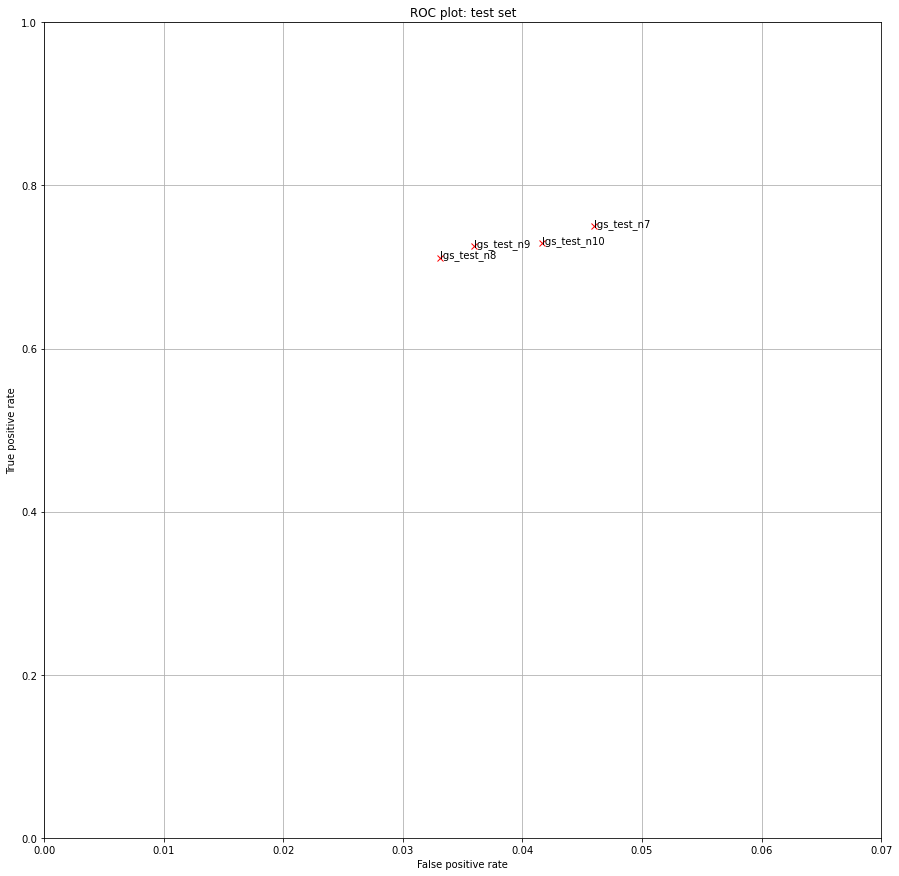

In [250]:
fits = [lgs_performance_test_n10, lgs_performance_test_n9, lgs_performance_test_n8, lgs_performance_test_n7]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'rx')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
    
# fits = [nbs_performance_train, nbs_performance_train_1, nbs_performance_train_3, nbs_performance_train_n1, nbs_performance_train_n3, nbs_performance_train_n5, nbs_performance_train_n7]

# for fit in fits:
#     plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
#              fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
#     plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
#              fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)    

plt.axis([0, 0.07, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.rcParams['figure.figsize'] = (15, 15)
plt.grid(b=True)
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [200]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='/Users/Charles/Desktop/ML/A1/toxiccomments_test.csv', my_random_seed=36, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 5 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 4096)
Shape of HashingVectorizer char n_gram X:
(153164, 4096)
Look at a few rows of the new quantitative features: 
   consCaps_count  consCaps_ratio  consCapsword_ratio  punc_q_ratio  \
0               0        0.000000            0.000000      0.009009   
1               1        0.02000

In [ ]:
# for 2 HashingV passed through respective tfidf transformer and then hstacked with quantfeat: AttributeError: lower not found
# for 2 HashingV hstacked and passed through tfidf transformer: TypeError: 'coo_matrix' object is not subscriptable

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [202]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = lgs_n5.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.25276827452926276


In [203]:
raw_data.head()

,id,comment_text,char_count,Caps_count,Caps_ratio,word_count,char_ratio,punc_count_p,punc_count_exc,punc_count_q,...,punc_ratio,punc_exc_ratio,punc_q_ratio,Capsword_ratio,spaces_count,spaces_ratio,spaceswords_ratio,consCaps_count,consCaps_ratio,consCapsword_ratio
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,367,4,0.000003,72,5.097222,10,0,0,...,0.152778,0.009009,0.009009,0.208333,71,0.193460,0.986111,0,0.00,0.000000
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,50,7,0.004096,13,3.846154,1,0,0,...,0.153846,0.047619,0.047619,0.692308,12,0.240000,0.923077,1,0.02,0.076923
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",54,4,0.000794,16,3.375000,0,0,0,...,0.062500,0.090909,0.090909,0.312500,15,0.277778,0.937500,0,0.00,0.000000
3,00017563c3f7919a,":If you have a look back at the source, the in...",205,4,0.000015,38,5.394737,3,0,0,...,0.105263,0.024390,0.024390,0.210526,37,0.180488,0.973684,0,0.00,0.000000
4,00017695ad8997eb,I don't anonymously edit articles at all.,41,1,0.000116,7,5.857143,1,0,0,...,0.142857,0.090909,0.090909,0.285714,6,0.146341,0.857143,0,0.00,0.000000


In [204]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,False
2,00013b17ad220c46,False
3,00017563c3f7919a,False
4,00017695ad8997eb,False


In [205]:
my_submission.shape

(153164, 2)

In [206]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/Users/Charles/Desktop/ML/A1/toxiccomments_submission_2.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation